<a href="https://colab.research.google.com/github/madhav2381/Twitter-Sentiment-Analysis/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wordsegment
!pip install autocorrect

     |████████████████████████████████| 4.8 MB 24.2 MB/s 
     |████████████████████████████████| 622 kB 22.1 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.0-py3-none-any.whl size=622249 sha256=097650a95360fa5104f52f3cf208d066dee885ee423c96a59cb4fa36db2a4af0
  Stored in directory: /root/.cache/pip/wheels/fa/ce/aa/bc894efbe0541ce91dea21561d01d319783986d9787a8e9f58
Successfully built autocorrect


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers.normalization import batch_normalization
from keras.layers import Activation, Dense, Dropout, Dropout, Flatten, BatchNormalization, Input, Embedding, Bidirectional, LSTM
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras import utils
from keras import backend as K
from keras.models import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D
import bs4
import nltk
from sklearn.metrics import confusion_matrix
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/training-Obama-Romney-tweets.rar' '/content'
!unrar x 'training-Obama-Romney-tweets.rar'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from training-Obama-Romney-tweets.rar

Extracting  training-Obama-Romney-tweets.xlsx                             99%  OK 
All OK


In [ ]:
data = pd.read_excel("/content/training-Obama-Romney-tweets.xlsx", sheet_name = ['Obama', 'Romney'])
data.keys()

dict_keys(['Obama', 'Romney'])

In [ ]:
d1 = data['Obama']
d2 = data['Romney']

In [ ]:
d1.head()

,Unnamed: 0,date,time,Anootated tweet,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,NaN,NaN,NaN,"1: positive, -1: negative, 0: neutral, 2: mixed",Class,Your class,NaN
1,NaN,2012-10-16 00:00:00,10:28:53-05:00,"Kirkpatrick, who wore a baseball cap embroider...",0,NaN,NaN
2,NaN,2016-12-10 00:00:00,10:09:00-05:00,Question: If <e>Romney</e> and <e>Obama</e> ha...,2,NaN,NaN
3,NaN,2012-10-16 00:00:00,10:04:30-05:00,#<e>obama</e> debates that Cracker Ass Cracker...,1,NaN,NaN
4,NaN,2012-10-16 00:00:00,10:00:36-05:00,RT @davewiner Slate: Blame <e>Obama</e> for fo...,2,NaN,NaN


In [ ]:
d2.head()

,Unnamed: 0,date,time,Anootated tweet,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,NaN,NaN,NaN,"1: positive, -1: negative, 0: neutral, 2: mixed",Class,Your class label,NaN
1,NaN,2012-10-16 00:00:00,09:38:08-05:00,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1,NaN,NaN
2,NaN,2012-10-16 00:00:00,10:22:34-05:00,Senior <e>Romney</e> Advisor Claims <e>Obama</...,2,NaN,NaN
3,NaN,2012-10-16 00:00:00,10:14:18-05:00,.@WardBrenda @shortwave8669 @allanbourdius you...,-1,NaN,NaN
4,NaN,2012-10-16 00:00:00,09:27:16-05:00,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1,NaN,NaN


In [ ]:
d1.drop(labels = ['Unnamed: 0', 'Unnamed: 5', 'Unnamed: 6', 'date','time'], axis=1, inplace=True)
d2.drop(labels = ['Unnamed: 0', 'Unnamed: 5', 'Unnamed: 6','date','time'], axis=1, inplace=True)
d1.drop(0, inplace=True)
d2.drop(0, inplace=True)

In [ ]:
train_data = d1.append(d2)
train_data.head()

,Anootated tweet,Unnamed: 4
1,"Kirkpatrick, who wore a baseball cap embroider...",0
2,Question: If <e>Romney</e> and <e>Obama</e> ha...,2
3,#<e>obama</e> debates that Cracker Ass Cracker...,1
4,RT @davewiner Slate: Blame <e>Obama</e> for fo...,2
5,@Hollivan @hereistheanswer Youre missing the ...,0


In [ ]:
train_data.rename(columns = {'Anootated tweet' : 'Annotated tweet', 'Unnamed: 4': 'class'}, inplace = True)
#d2.rename(columns = {'Anootated tweet' : 'Annotated tweet', 'Unnamed: 4': 'class'}, inplace = True)

In [ ]:
train_data.dropna(how='any',subset = ['Annotated tweet', 'class'],inplace =True)
#d2.dropna(how='any',subset = ['Annotated tweet', 'class'],inplace =True)

In [ ]:
train_data = train_data[(train_data['class'] == 1) | (train_data['class'] == 0) | (train_data['class'] == -1) | (train_data['class'] == '1') | (train_data['class'] == '0') | (train_data['class'] == '-1')]

In [ ]:
train_data['class'] = train_data['class'].astype('int64')

In [ ]:
train_data['class'].value_counts()

-1    4861
 0    3657
 1    2754
Name: class, dtype: int64

In [ ]:
train_data.shape

(11272, 2)

**DATA CLEANING**

In [ ]:
#Contractions Dictionary
import re
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the CONTENT feature
train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda x:expand_contractions(x))

In [ ]:
# check if still there are any contractions
for text in train_data['Annotated tweet'].to_list():
    r = contractions_re.findall(text)
print(r)

[]


In [ ]:
# Clean Data
def read_obama_data():
    data = pd.read_excel('/content/final-testData-no-label-Obama-tweets(2).xlsx', header = None)
    data.rename(columns={ 0: 'index', 1:'Annotated tweet'}, inplace =True)
    data.drop(labels = ['index'],  axis = 1, inplace = True)
    return data

def read_romney_data():
    data = pd.read_excel('/content/final-testData-no-label-Romney-tweets(2).xlsx', header = None)
    data.rename(columns={ 0: 'index', 1:'Annotated tweet'}, inplace =True)
    data.drop(labels = ['index'],  axis = 1, inplace = True)
    return data

def clean_data(train_data):
    train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda x:expand_contractions(x))
    train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda x: bs4.BeautifulSoup(x, 'lxml').get_text())
    train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda x: extract_words(x))
    train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda tweet: ' '.join(re.sub("(@[A-Za-z0–9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())) 
    train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda x: re.sub('\w*\d\w*','', x))
    train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda x: x.lower())
    train_data['Annotated tweet'] = train_data['Annotated tweet'].replace('\s+', ' ', regex=True)
    #train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    #train_data['tweet_without_stopwords'] = train_data
    train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(norm_lemm_v_a_func)
    train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda text : ' '.join([word for word in text.split() if len(word) > 1]))
    train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda text : multiple_word_remove_func(text, words_list))
    return train_data['Annotated tweet']

def to_vectors(data):
    data =  tfidf_vect.transform(data)
    return data

def save_obama_predictions(data):
    preds_array = clf.predict(data)
    with open('Obama.txt', 'w') as writefile:
        writefile.write('82 98')
        writefile.write("\n")
        for index,prediction in enumerate(preds_array):
            writefile.write(str(index+1)+';;'+ str(prediction))
            writefile.write("\n")
    files.download('Obama.txt')

def save_romney_predictions(data):
    preds_array = clf.predict(data)
    with open('Romney.txt', 'w') as writefile:
        writefile.write('82 98')
        writefile.write("\n")
        for index,prediction in enumerate(preds_array):
            writefile.write(str(index+1)+';;'+ str(prediction))
            writefile.write("\n")
    files.download('Romney.txt')

In [ ]:
obama = read_obama_data()
obama = clean_data(obama)
obama = to_vectors(obama)
save_obama_predictions(obama)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
romney = read_romney_data()
romney = clean_data(romney)
romney = to_vectors(romney)
save_romney_predictions(romney)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Removes html tags 
train_data['Annotated tweet']=train_data['Annotated tweet'].apply(lambda x: bs4.BeautifulSoup(x, 'lxml').get_text())

In [ ]:
# Splits Hashtags
import wordsegment as ws
ws.load()
def extract_words(tweet):
    hashtags = re.findall(r"(#\w+)", tweet)
    for hs in hashtags:
        words = " ".join(ws.segment(hs))
        tweet = tweet.replace(hs, words)
    return tweet


train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda x: extract_words(x))

In [ ]:
# removes urls, punctuations, emojis, hastags, mentions.
train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda tweet: ' '.join(re.sub("(@[A-Za-z0–9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())) 

In [ ]:
# Remove digits and words with digits
train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [ ]:
# Convert to lowercase
train_data['Annotated tweet'] = train_data['Annotated tweet'].apply(lambda x: x.lower())

In [ ]:
# Remove extra spaces
train_data['Annotated tweet'] = train_data['Annotated tweet'].replace('\s+', ' ', regex=True)

In [ ]:
# Remove STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

train_data['tweet_without_stopwords'] = train_data['Annotated tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_data['tweet_without_stopwords'] = train_data['Annotated tweet']

In [ ]:
# Num of words in the data after removing stopwords
train_data['tweet_without_stopwords'].apply(lambda x: len(x.split(' '))).sum()

167865

In [ ]:
# unique words in the data
li = []
for l in train_data['tweet_without_stopwords'].apply(lambda x: x.split(' ')).to_list():
    li = li + l
len(set(li))
# train_data['tweet_without_stopwords'].apply(lambda x: len(x.split(' '))).sum()

12012

In [ ]:
max([len(x) for x in train_data['tweet_without_stopwords']])

171

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
def norm_lemm_v_a_func(text):
    words1 = word_tokenize(text)
    text1 = ' '.join([WordNetLemmatizer().lemmatize(word, pos='v') for word in words1])
    words2 = word_tokenize(text1)
    text2 = ' '.join([WordNetLemmatizer().lemmatize(word, pos='a') for word in words2])
    return text2

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#normalization - lemmatizing
nltk.download('punkt')
train_data['tweet_without_stopwords'] = train_data['tweet_without_stopwords'].apply(norm_lemm_v_a_func)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Remove single characters
train_data['tweet_without_stopwords'] = train_data['tweet_without_stopwords'].apply(lambda text : ' '.join([word for word in text.split() if len(word) > 1]))

In [ ]:
from nltk.probability import FreqDist
def most_freq_word_func(text, n_words=5):
    words = word_tokenize(text)
    fdist = FreqDist(words) 
    
    df_fdist = pd.DataFrame({'Word': fdist.keys(),
                             'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)
    
    n_words = n_words
    most_freq_words_list = list(df_fdist['Word'][0:n_words])
    
    return most_freq_words_list

In [ ]:
def most_rare_word_func(text, n_words=5):
    words = word_tokenize(text)
    fdist = FreqDist(words) 
    
    df_fdist = pd.DataFrame({'Word': fdist.keys(),
                             'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)
    
    n_words = n_words
    most_rare_words_list = list(df_fdist['Word'][-n_words:])
    
    return most_rare_words_list

In [ ]:
text_corpus_original = train_data['tweet_without_stopwords'].str.cat(sep=' ')
most_freq_words_list_DataFrame = most_freq_word_func(text_corpus_original, n_words=10)
most_rare_words_list_DataFrame = most_rare_word_func(text_corpus_original, n_words=30)
words_list = most_freq_words_list_DataFrame + most_rare_words_list_DataFrame
words_list = [word for word in words_list if word != 'not' ]


In [ ]:
def multiple_word_remove_func(text, words_2_remove_list):
    words_to_remove_list = words_2_remove_list
    words = word_tokenize(text)
    text = ' '.join([word for word in words if word not in words_to_remove_list])
    return text

In [ ]:
# Remove Most common and Rarest words
train_data['tweets_wo_freq_words'] = train_data['tweet_without_stopwords'].apply(lambda text : multiple_word_remove_func(text, words_list))

In [ ]:
'''
from sklearn.model_selection import train_test_split
data1= train_data['tweets_wo_freq_words']
labels = train_data['class']
X_train,X_test,Y_train,Y_test = train_test_split(data1, labels, test_size=0.2)
'''

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect.fit(train_data['tweets_wo_freq_words'])
X_train =  tfidf_vect.transform(train_data['tweets_wo_freq_words'])
Y_train = train_data['class']
#X_test =  tfidf_vect.transform(X_test)

# LR

In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
clf = LogisticRegression(max_iter=1000)
scores = cross_validate(clf, X_train, Y_train, cv=5, return_train_score=False, n_jobs=-1)
clf.fit(X_train, Y_train)
print("cv test score",scores['test_score'].mean())

'''
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print('accuracy %s' % accuracy_score(Y_test, y_pred))
print(classification_report( Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
'''

cv test score 0.5613873537460872


"\ny_pred = clf.predict(X_test)\nfrom sklearn.metrics import classification_report, accuracy_score, confusion_matrix\nprint('accuracy %s' % accuracy_score(Y_test, y_pred))\nprint(classification_report( Y_test, y_pred))\nprint(confusion_matrix(Y_test, y_pred))\n"

# SGD

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 )
scores = cross_validate(sgd, X_train, Y_train, cv=5, return_train_score=False, n_jobs=-1)
print("cv test score",scores['test_score'].mean())
sgd.fit(X_train,Y_train)
'''
y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(Y_test, y_pred))
print(classification_report( Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
'''

cv test score 0.5309583947335803


"\ny_pred = sgd.predict(X_test)\nprint('accuracy %s' % accuracy_score(Y_test, y_pred))\nprint(classification_report( Y_test, y_pred))\nprint(confusion_matrix(Y_test, y_pred))\n"

# Naive Baye's

In [ ]:
# Naive baye's

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
scores = cross_validate(nb, X_train, Y_train, cv=5, return_train_score=False, n_jobs=-1)
print("cv test score",scores['test_score'].mean())
nb.fit(X_train, Y_train)
'''
y_pred = nb.predict(X_test)
print('accuracy %s' % accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
'''

cv test score 0.5265224277313354


"\ny_pred = nb.predict(X_test)\nprint('accuracy %s' % accuracy_score(Y_test, y_pred))\nprint(classification_report(Y_test, y_pred))\nprint(confusion_matrix(Y_test, y_pred))\n"

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42)
scores = cross_validate(rf, X_train, Y_train, cv=5, return_train_score=False, n_jobs=-1)
print("cv test score",scores['test_score'].mean())
rf.fit(X_train, Y_train)
'''
y_pred = rf.predict(X_test)
print('accuracy %s' % accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
'''

cv test score 0.5514519445105719


"\ny_pred = rf.predict(X_test)\nprint('accuracy %s' % accuracy_score(Y_test, y_pred))\nprint(classification_report(Y_test, y_pred))\nprint(confusion_matrix(Y_test, y_pred))\n"

# XgBoost

In [ ]:
from xgboost import XGBClassifier
#fit_params={'early_stopping_rounds':10}
xgb = XGBClassifier(n_estimators=1000, subsample=0.8)
scores = cross_validate(xgb, X_train, Y_train, cv=5, return_train_score=False, n_jobs=-1)
print("cv test score",scores['test_score'].mean())
xgb.fit(X_train, Y_train)
'''
y_pred = xgb.predict(X_test)
print('accuracy %s' % accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
'''

cv test score 0.5498559250172642


"\ny_pred = xgb.predict(X_test)\nprint('accuracy %s' % accuracy_score(Y_test, y_pred))\nprint(classification_report(Y_test, y_pred))\nprint(confusion_matrix(Y_test, y_pred))\n"

# SVM

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_validate
s = svm.SVC(kernel = 'linear', gamma=0.1)
scores = cross_validate(s, X_train, Y_train, cv=5, return_train_score=False, n_jobs=-1)
print("cv test score",scores['test_score'].mean())
s.fit(X_train, Y_train)

'''
y_pred = s.predict(X_test)
print('accuracy %s' % accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
'''

cv test score 0.5550000885344015


"\ny_pred = s.predict(X_test)\nprint('accuracy %s' % accuracy_score(Y_test, y_pred))\nprint(classification_report(Y_test, y_pred))\nprint(confusion_matrix(Y_test, y_pred))\n"

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
# defining parameter range
param_grid = { 'C':[0.1,1,100,1000],'kernel':['linear'],'degree':[3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, Y_train)
grid_search.best_params_

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END C=0.1, degree=3, gamma=1, kernel=linear;, score=0.503 total time=  14.8s
[CV 2/5] END C=0.1, degree=3, gamma=1, kernel=linear;, score=0.504 total time=  15.8s
[CV 3/5] END C=0.1, degree=3, gamma=1, kernel=linear;, score=0.496 total time=  14.8s
[CV 4/5] END C=0.1, degree=3, gamma=1, kernel=linear;, score=0.465 total time=  15.3s
[CV 5/5] END C=0.1, degree=3, gamma=1, kernel=linear;, score=0.469 total time=  15.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.1, kernel=linear;, score=0.503 total time=  15.1s
[CV 2/5] END C=0.1, degree=3, gamma=0.1, kernel=linear;, score=0.504 total time=  14.6s
[CV 3/5] END C=0.1, degree=3, gamma=0.1, kernel=linear;, score=0.496 total time=  15.1s
[CV 4/5] END C=0.1, degree=3, gamma=0.1, kernel=linear;, score=0.465 total time=  14.7s
[CV 5/5] END C=0.1, degree=3, gamma=0.1, kernel=linear;, score=0.469 total time=  15.2s
[CV 1/5] END C=0.1, degree=3, gamma=0.01, kernel=linear;, score=0.50

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=1000, validation_fraction=0.2, n_iter_no_change=10, tol=0.01, random_state=0, verbose=0 )
scores = cross_validate(gbc, X_train, Y_train, cv=5, return_train_score=False, n_jobs=-1)
print("cv test score",scores['test_score'].mean())
gbc.fit(X_train, Y_train)
'''
y_pred = gbc.predict(X_test)
print('accuracy %s' % accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))
'''

cv test score 0.5007070947534513


"\ny_pred = gbc.predict(X_test)\nprint('accuracy %s' % accuracy_score(Y_test, y_pred))\nprint(classification_report(Y_test, y_pred))\nprint(confusion_matrix(Y_test, y_pred))\n"

In [ ]:
from sklearn.model_selection import learning_curve, GridSearchCV

parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    #"clf__max_iter": (20,),
    "clf__alpha": (1, 0.1, 0.001, 0.0001, 0.00001, 0.000001),
    "clf__penalty": ("l2", "elasticnet"),
    'clf__max_iter': (5, 10, 20, 50, 80),
}

pipeline = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier())
               ])

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
	clf__alpha: 0.0001
	clf__max_iter: 5
	clf__penalty: 'elasticnet'
	vect__max_df: 1.0
	vect__max_features: 50000
	vect__ngram_range: (1, 2)


In [ ]:
grid_search.score(X_test, Y_test)

0.5960088691796009

# DEEP LEARNING MODELS

In [ ]:
from keras.preprocessing.text import Tokenizer
max_words = 10000
max_len = 150
tokenize = Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_data['tweet_without_stopwords']) 
sequences = tokenize.texts_to_sequences(train_data['tweet_without_stopwords'])
data = pad_sequences(sequences, maxlen=max_len)

In [ ]:
from keras.preprocessing.text import Tokenizer
max_words = 12000
max_len = 150
tokenize = Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_data['tweets_wo_freq_words']) 
sequences = tokenize.texts_to_sequences(train_data['tweets_wo_freq_words'])
data = pad_sequences(sequences, maxlen=max_len)

In [ ]:
labels = tf.keras.utils.to_categorical(train_data['class'], 3, dtype="float32")

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data, labels, test_size=0.2)

In [ ]:
X_train.shape

(9017, 150)

In [ ]:
Y_train.shape

(9017, 3)

# ANN

In [ ]:
# simple NN

batch_size = 32
max_len = 150
model = Sequential()
model.add(Dense(512, input_shape=(max_len,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/20
254/254 [==============================] - 3s 5ms/step - loss: 65.9411 - accuracy: 0.3667 - val_loss: 1.0850 - val_accuracy: 0.4457
Epoch 2/20
254/254 [==============================] - 1s 4ms/step - loss: 2.1368 - accuracy: 0.4218 - val_loss: 1.0753 - val_accuracy: 0.4457
Epoch 3/20
254/254 [==============================] - 1s 5ms/step - loss: 1.4305 - accuracy: 0.4267 - val_loss: 1.0711 - val_accuracy: 0.4457
Epoch 4/20
254/254 [==============================] - 1s 5ms/step - loss: 1.1974 - accuracy: 0.4313 - val_loss: 1.0703 - val_accuracy: 0.4457
Epoch 5/20
254/254 [==============================] - 1s 4ms/step - loss: 1.2827 - accuracy: 0.4315 - val_loss: 1.0704 - val_accuracy: 0.4457
Epoch 6/20
254/254 [==============================] - 1s 4ms/step - loss: 1.1448 - accuracy: 0.4330 - val_loss: 1.0705 - val_accuracy: 0.4457
Epoch 7/20
254/254 [==============================] - 1s 4ms/step - loss: 1.1211 - accuracy: 0.4325 - val_loss: 1.0705 - val_accuracy: 0.4457
Epoch

In [ ]:
score = model.evaluate(X_test, Y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

71/71 [==============================] - 0s 3ms/step - loss: 1.0797 - accuracy: 0.4195
Test accuracy: 0.41951218247413635


In [ ]:
'''
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it
'''

# BiDirectional LSTM

In [ ]:
#BiDirectional LSTM

batch_size = 32
epochs = 100
max_len = 150
model = Sequential()
model.add(Embedding(3000, 128, input_length=max_len))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint('BiLstm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=2, epsilon=1e-4, mode='min')
callbacks=[earlyStopping,reduce_lr_loss,mcp_save]

model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, Y_test), callbacks = callbacks)

Epoch 1/100
282/282 [==============================] - 25s 77ms/step - loss: 0.5936 - accuracy: 0.4952 - val_loss: 0.5516 - val_accuracy: 0.5761 - lr: 0.0010
Epoch 2/100
282/282 [==============================] - 21s 74ms/step - loss: 0.5087 - accuracy: 0.6234 - val_loss: 0.5333 - val_accuracy: 0.5849 - lr: 0.0010
Epoch 3/100
282/282 [==============================] - 21s 74ms/step - loss: 0.4488 - accuracy: 0.6871 - val_loss: 0.5520 - val_accuracy: 0.5765 - lr: 0.0010
Epoch 4/100
282/282 [==============================] - 21s 74ms/step - loss: 0.4082 - accuracy: 0.7261 - val_loss: 0.5772 - val_accuracy: 0.5778 - lr: 0.0010
Epoch 5/100
282/282 [==============================] - 21s 73ms/step - loss: 0.3745 - accuracy: 0.7555 - val_loss: 0.5978 - val_accuracy: 0.5685 - lr: 0.0010
Epoch 6/100
282/282 [==============================] - 21s 73ms/step - loss: 0.3359 - accuracy: 0.7847 - val_loss: 0.6575 - val_accuracy: 0.5623 - lr: 0.0010
Epoch 7/100
282/282 [==============================]

In [ ]:
score = model.evaluate(X_test, Y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

71/71 [==============================] - 2s 23ms/step - loss: 1.0058 - accuracy: 0.5561
Test accuracy: 0.5560975670814514


In [ ]:
from google.colab import files
files.download('my_best_model.hdf5')

In [ ]:
from google.colab import files
files.upload()

# Transfer learning

In [ ]:
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.KerasLayer(module_url, trainable=False, name='USE_embedding')
def build_model(embed):
    model = Sequential([
        Input(shape=(max_len,), dtype=tf.string),
        embed,
        Dense(1024, activation='elu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='elu'),
        BatchNormalization(),
        Dropout(0.35),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(3, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam(lr = 0.001)
    model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
    
model = build_model(embed)
model.summary()

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test,Y_test),
    epochs=35,
    callbacks=[earlyStopping,reduce_lr_loss,mcp_save],
    batch_size= 32 
)

In [ ]:
# TCN

def tcn_model(kernel_size = 3, activation='relu', input_dim = None, 
                   output_dim=300, max_length = None, emb_matrix = None):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, 
                  output_dim=output_dim, 
                  input_length=max_length,
                  # Assign the embedding weight with word2vec embedding marix
                  weights = [emb_matrix],
                  # Set the weight to be not trainable (static)
                  trainable = False)(inp)
    
    x = SpatialDropout1D(0.1)(x)
    
    x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(64,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(3, activation="softmax")(conc)    

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [ ]:
model = tcn_model(kernel_size = 3, activation='relu', input_dim = 2000, output_dim=300, max_length = 12000, emb_matrix = None)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint('Transfer_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=2, epsilon=1e-4, mode='min')
callbacks=[earlyStopping,reduce_lr_loss,mcp_save]

model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_test, Y_test), callbacks = callbacks)

#Model Comparision

In [ ]:
import matplotlib.pyplot as plt

<BarContainer object of 10 artists>

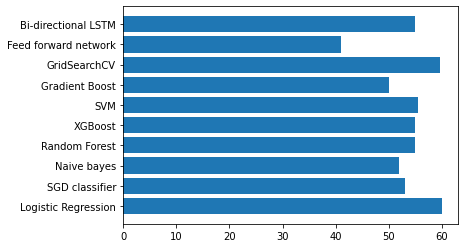

In [ ]:
models = ['Logistic Regression', 'SGD classifier', 'Naive bayes', 'Random Forest', 'XGBoost', 'SVM', 'Gradient Boost', 'GridSearchCV', 'Feed forward network', 'Bi-directional LSTM']
acc = [60, 53, 52, 55, 55, 55.5, 50, 59.6, 41, 55]
plt.barh(models, acc, align='center')